In [ ]:
path = '/content/drive/My Drive/data/'
cmds = []
labels = []
def addLines(pth,lbl):
  global cmds,labels
  f = open(pth)
  l = f.readline()
  while l:
    l = l[0:len(l)-1]
    if l not in cmds:
      cmds.append(l)
      labels.append(lbl)
    l = f.readline()
  f.close()

In [ ]:
addLines(path+'command_dataset/forward.txt','forward')
addLines(path+'command_dataset/syn_forward.txt','forward')
addLines(path+'command_dataset/backward.txt','backward')
addLines(path+'command_dataset/syn_backward.txt','backward')
addLines(path+'command_dataset/right.txt','right')
addLines(path+'command_dataset/syn_right.txt','right')
addLines(path+'command_dataset/left.txt','left')
addLines(path+'command_dataset/syn_left.txt','left')

In [3]:
dataset = list(zip(cmds,labels))
import random
random.shuffle(dataset)
X = []
Y = []
i=1
for e in dataset:
  X.append(e[0])
  Y.append(e[1])
  print(i,e[0],' : ',e[1])
  i = i+1

1 drive cover  :  backward
2 switch straight backward  :  backward
3 can you move a step forward  :  forward
4 keep the fuck away from me  :  backward
5 can you go yourself left  :  left
6 move to the right hand side  :  right
7 hello could you turn a little bit to your left  :  left
8 now face up on the right manus  :  right
9 oh step back to stay away from me  :  backward
10 can you move yourself right  :  right
11 go backwards and stand far away from me  :  backward
12 come on to your left and sit in there  :  left
13 come here quickly get tight to me  :  forward
14 ya you should step back a little bit  :  backward
15 proceed forward  :  forward
16 can you please take a left turn  :  left
17 leave right away  :  backward
18 turn to your right side  :  right
19 now switch on the left over hired hand yes  :  left
20 i am asking you to move in right direction  :  right
21 face right  :  right
22 advance to your left field  :  left
23 could you come by a little bit please  :  forward
24

In [4]:
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % len(tokenizer.word_index))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
MAX_LEN = max(len(l) for l in (x_train+x_test))

x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LEN)

total_class = ["forward", "backward", "right", "left"]
mapping = {}
for x in range(len(total_class)):
  mapping[total_class[x]] = x
for x in range(len(y_train)):
  y_train[x] = mapping[y_train[x]]
for x in range(len(y_test)):
  y_test[x] = mapping[y_test[x]]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
reverse_word_map[0] = ''
def sequence_to_text(list_of_indices):
    words = [reverse_word_map[ind] for ind in list_of_indices]
    return ' '.join(words)

Found 426 unique tokens.


In [ ]:
for i in range(len(x_train)):
  print(i,sequence_to_text(x_train[i]),' : Actual - ',total_class[np.argmax(y_train[i])])

# for i in range(len(x_test)):
#   print(i,sequence_to_text(x_test[i]),' : Actual - ',total_class[np.argmax(y_test[i])])

0 step to your unexpended side          : Actual -  left
1 drive forward             : Actual -  forward
2 could you please push a little backwards        : Actual -  backward
3 hi you should step gage a little morsel       : Actual -  backward
4 look through the left eye          : Actual -  left
5 keep the fuck away from me         : Actual -  backward
6 go away backwards and support far away from me      : Actual -  backward
7 go onwards and come near me         : Actual -  forward
8 take the left turn           : Actual -  left
9 now move ahead            : Actual -  forward
10 please stair towards your right          : Actual -  right
11 stay away from me           : Actual -  backward
12 hello could you turn a little bit to your left field    : Actual -  left
13 go ahead             : Actual -  forward
14 if possible please plough a little to your leftfield      : Actual -  left
15 please do a favour by ill treat in backward direction     : Actual -  backward
16 hey come in and l

In [ ]:
from gensim.models import KeyedVectors
path = '/content/drive/My Drive/data/'
w2v = KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# v = w2v['spirit']
# print(v)
# Favour To A And Of Counselling Flavour Plough Whitethorn

In [ ]:
bugCase = {'to':'To','a':'A','and':'And','of':'Of','flavour':'Flavour','counselling':'Counselling','whitethorn':'Whitethorn','plough':'Plough','favour':'Favour'}

embedding_matrix = np.zeros((vocab_size, 300))
not_found = 1
for word, index in tokenizer.word_index.items():
    try:
      if word in bugCase.keys():
        word = bugCase[word]
      embedding_vector = w2v[word]
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    except:
      print(not_found,word)
      not_found += 1

In [ ]:
deep_inputs = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer = LSTM(128)(embedding_layer)
dense_layer = Dense(4, activation='softmax')(LSTM_Layer)
model = Model(inputs=deep_inputs, outputs=dense_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 13, 300)           128100    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 348,264
Trainable params: 220,164
Non-trainable params: 128,100
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size=30, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
23/23 [==============================] - 1s 53ms/step - loss: 1.2037 - categorical_accuracy: 0.4852 - val_loss: 0.7736 - val_categorical_accuracy: 0.7160
Epoch 2/6
23/23 [==============================] - 1s 28ms/step - loss: 0.4993 - categorical_accuracy: 0.8506 - val_loss: 0.3181 - val_categorical_accuracy: 0.9112
Epoch 3/6
23/23 [==============================] - 1s 26ms/step - loss: 0.2061 - categorical_accuracy: 0.9408 - val_loss: 0.2025 - val_categorical_accuracy: 0.9408
Epoch 4/6
23/23 [==============================] - 1s 27ms/step - loss: 0.1264 - categorical_accuracy: 0.9630 - val_loss: 0.1872 - val_categorical_accuracy: 0.9290
Epoch 5/6
23/23 [==============================] - 1s 26ms/step - loss: 0.0810 - categorical_accuracy: 0.9719 - val_loss: 0.1913 - val_categorical_accuracy: 0.9467
Epoch 6/6
23/23 [==============================] - 1s 26ms/step - loss: 0.0687 - categorical_accuracy: 0.9822 - val_loss: 0.1763 - val_categorical_accuracy: 0.9586


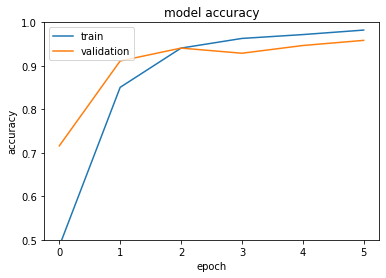

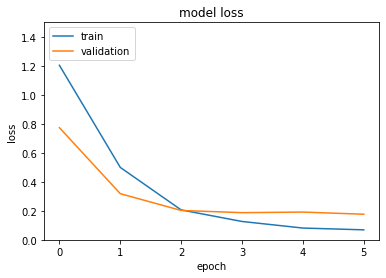

3/3 [==============================] - 0s 7ms/step - loss: 0.2071 - categorical_accuracy: 0.9468
Test Score: 0.2071150541305542
Test Accuracy: 0.9468085169792175


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.ylim(0.5,1)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.ylim(0,1.5)
plt.show()

score = model.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
ans = model.predict(x_test)
for i in range(len(x_test)):
  if total_class[np.argmax(y_test[i])] != total_class[np.argmax(ans[i])]:
    print('###################')
  print(sequence_to_text(x_test[i]),' : Actual - ',total_class[np.argmax(y_test[i])], ' : Predicted - ',total_class[np.argmax(ans[i])])

switch right now            : Actual -  right  : Predicted -  right
could you please move a little finisher        : Actual -  forward  : Predicted -  forward
please set out away from me         : Actual -  backward  : Predicted -  backward
i want you to go very far from me      : Actual -  backward  : Predicted -  backward
come in to the left          : Actual -  left  : Predicted -  left
walk forward             : Actual -  forward  : Predicted -  forward
hi you should move a little to the right      : Actual -  right  : Predicted -  right
why constitute you not moving backward         : Actual -  backward  : Predicted -  backward
yea come over here sit down next to me      : Actual -  forward  : Predicted -  forward
please do a favor by stepping in backward direction      : Actual -  backward  : Predicted -  backward
hey come near me           : Actual -  forward  : Predicted -  forward
ya would you move a little to the left      : Actual -  left  : Predicted -  left
hey come here g

In [ ]:
model.save(path+'new.h5')